In [ ]:
import os

os.environ["WANDB_PROJECT"] = "Fine-tuning gemma-7b-it"
os.environ["WANDB_NAME"] = "final-ft-google-gemma-7b-it-qlora"
os.environ["MODEL_NAME"] = "google/gemma-7b-it"
os.environ["TOKENIZERS_PARALLELISM"] = "true"

from google.colab import userdata
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

In [ ]:
#!pip install transformers datasets accelerate peft trl bitsandbytes wandb

!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets bitsandbytes einops wandb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.cuda.is_available()

True

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import json

# Loading & Preprocessing Kaggle Dataset
with open('/content/drive/MyDrive/kaggle_qa_master_train.json','r') as f:
    kaggle_data = json.load(f)
print(kaggle_data[0])

{'input': "Competitions\nFind challenges for every interest level\nTypes of Competitions  \nKaggle Competitions are designed to provide challenges for competitors at all different stages of their machine learning careers. As a result, they are very diverse, with a range of broad types.\n\nGetting Started\nFeatured Competitions are a great way to begin with machine learning competitions, especially if you're new to the field. They offer a variety of learning resources and a supportive community to help you get started.", 'instruction': 'Identify two distinct categories of competitions mentioned in the text.', 'output': 'The text mentions "Featured Competitions" and alludes to a broader range of competition types within "Kaggle Competitions."'}


In [ ]:
kaggle_df = pd.DataFrame(kaggle_data)
kaggle_df.sample(5)

,input,instruction,output
238,Various tutorials (http://blog.kaggle.com/cate...,Who provides a detailed explanation on the key...,"Marios Michailidis (Kasanova), a top Kaggler, ..."
69,What are the compute limits of Notebooks?\nThe...,Explain the purpose of 'Notebook Commits'.,'Notebook Commits' serve as snapshots of Noteb...
296,SQLite\n Kaggle supports database files usi...,Is it true that SQLite and CSV files on Kaggle...,False. SQLite and CSV files on Kaggle have sim...
1320,Prepare the dataset\n\nOverview\n\nYou will ty...,What information is provided in the `test.csv`...,The `test.csv` file contains the features of t...
557,“ Deep Learning Support [.9663] (https://www.k...,True or False: The example provided showcases ...,True. The “Deep Learning Support [.9663]” Note...


In [ ]:
with open('/content/drive/MyDrive/kaggle_qa_master_test.json','r') as f:
    kaggle_test_data = json.load(f)
print(kaggle_test_data[0])

{'input': 'Competitions\nFind challenges for every interest level\nTypes of Competitions\nKaggle Competitions are designed to provide challenges for competitors at all different stages of their machine learning careers. As a result, they are very diverse, with a range of broad types.', 'instruction': 'What is the goal of Kaggle Competitions?', 'output': 'Kaggle Competitions aim to provide challenges for competitors at all stages of their machine learning careers.'}


In [ ]:
kaggle_test_df = pd.DataFrame(kaggle_test_data)
kaggle_test_df.sample(5)

,input,instruction,output
777,If you want to share private datasets or model...,How can private datasets or models owned by an...,By using Collaboration features.
324,"To enable these integrations, click on the “Ad...",What action should be taken to enable Google C...,Click on the “Add-ons” menu in the notebook ed...
741,Can I upload a new solution file and rescore t...,Who can rescore a competition with a new solut...,An administrator
745,I want to give participants more time to compe...,Where can you change the competition deadline ...,Your competition > Host > Settings > Deadline
445,Tensor Processing Units (TPUs)\n\nTPUs are now...,What is the maximum amount of TPU time allowed...,20 hours


In [ ]:
print(kaggle_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1663 entries, 0 to 1662
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   input        1663 non-null   object
 1   instruction  1663 non-null   object
 2   output       1663 non-null   object
dtypes: object(3)
memory usage: 39.1+ KB
None


In [ ]:
import re
# Cleaning & formatting plain text data in Kaggle Dataset
def clean_text(text: str) -> str:
    text = re.sub(r'<[^>]+>', '', text) # remove HTML/Markdown tags
    text = re.sub(r'@\w+', '', text) # remove @user tags
    text = text.replace('\n', ' ') # remove newline characters
    text = re.sub(r'\s+', ' ', text) # remove multiple spaces
    text = text.strip() # remove leading and trailing spaces
    return text

kaggle_df['instruction'] = kaggle_df['instruction'].apply(clean_text)
kaggle_df['input'] = kaggle_df['input'].apply(clean_text)
kaggle_df['output'] = kaggle_df['output'].apply(clean_text)

kaggle_test_df['instruction'] = kaggle_test_df['instruction'].apply(clean_text)
kaggle_test_df['input'] = kaggle_test_df['input'].apply(clean_text)
kaggle_test_df['output'] = kaggle_test_df['output'].apply(clean_text)

In [ ]:
# Transforming our general dataframe into list with specified format of Questions & Answers.
kaggle_data = []

for _, row in kaggle_df.iterrows():
    kaggle_data.append(f'Question:\n{row["instruction"]}\n\Context:\n{row["input"]}\n\Answer:\n{row["output"]}')

kaggle_data[0:2]

['Question:\nIdentify two distinct categories of competitions mentioned in the text.\n\\Context:\nCompetitions Find challenges for every interest level Types of Competitions Kaggle Competitions are designed to provide challenges for competitors at all different stages of their machine learning careers. As a result, they are very diverse, with a range of broad types. Getting Started Featured Competitions are a great way to begin with machine learning competitions, especially if you\'re new to the field. They offer a variety of learning resources and a supportive community to help you get started.\n\\Answer:\nThe text mentions "Featured Competitions" and alludes to a broader range of competition types within "Kaggle Competitions."',
 "Question:\nSummarize the purpose of 'Featured Competitions'.\n\\Context:\nCompetitions Find challenges for every interest level Types of Competitions Kaggle Competitions are designed to provide challenges for competitors at all different stages of their mac

**Load Tokenizer**

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(os.getenv("MODEL_NAME"), use_fast=True)
tokenizer

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

GemmaTokenizerFast(name_or_path='google/gemma-7b-it', vocab_size=256000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<start_of_turn>', '<end_of_turn>']}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	5: AddedToken("<2mass>", rstrip=False, lstrip=False, single_w

**Split data: Test and Train**

In [ ]:
from datasets import load_dataset, Dataset

data=Dataset.from_pandas(kaggle_df)

data=data.map(lambda samples: tokenizer(samples["input"]), batched=True)
data=data.map(lambda samples: tokenizer(samples["instruction"]), batched=True)
data=data.map(lambda samples: tokenizer(samples["output"]), batched=True)


Map:   0%|          | 0/1663 [00:00<?, ? examples/s]

Map:   0%|          | 0/1663 [00:00<?, ? examples/s]

Map:   0%|          | 0/1663 [00:00<?, ? examples/s]

In [ ]:

data_valid=Dataset.from_pandas(kaggle_test_df)

data_valid=data_valid.map(lambda samples: tokenizer(samples["input"]), batched=True)
data_valid=data_valid.map(lambda samples: tokenizer(samples["instruction"]), batched=True)
data_valid=data_valid.map(lambda samples: tokenizer(samples["output"]), batched=True)

# Split the 95% test and 5% valid
data_valid=data_valid.train_test_split(test_size=0.95)

Map:   0%|          | 0/793 [00:00<?, ? examples/s]

Map:   0%|          | 0/793 [00:00<?, ? examples/s]

Map:   0%|          | 0/793 [00:00<?, ? examples/s]

In [ ]:
data

Dataset({
    features: ['input', 'instruction', 'output', 'input_ids', 'attention_mask'],
    num_rows: 1663
})

In [ ]:
data_valid

DatasetDict({
    train: Dataset({
        features: ['input', 'instruction', 'output', 'input_ids', 'attention_mask'],
        num_rows: 39
    })
    test: Dataset({
        features: ['input', 'instruction', 'output', 'input_ids', 'attention_mask'],
        num_rows: 754
    })
})

**Loading Model**

In [ ]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    os.getenv("MODEL_NAME"),
    quantization_config=bnb_config,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
model.config.eos_token_id=tokenizer.eos_token_id
model.gradient_checkpointing_enable() # reducing memory usage
print(model.model.embed_tokens)

Embedding(256000, 3072, padding_idx=0)


**Shows the total parameters and the trainable parameters in the model**

In [ ]:
def print_trainable_parameters(model):
    trainable_params=0
    all_params=0
    for _, param in model.named_parameters():
        all_params+=param.numel()
        if param.requires_grad:
            trainable_params+=param.numel()
    print(f"trainable params: {trainable_params} || all params: {all_params} || trainable%: {100 * trainable_params/all_params:.2f}")

print_trainable_parameters(model)

trainable params: 786607104 || all params: 4662144000 || trainable%: 16.87


**Inference before fine tuning**

In [ ]:
model.eval()

input_text = "What are the storage limits for datasets on Kaggle?"
instruction_text = "Please answer the following question."
prompt=f'''<start_of_turn>user Below is the instruction. \n\n###
Instruction:\n{instruction_text}\n###
Input:\n{input_text} <end_of_turn>
<start_of_turn>'''

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

outputs = model.generate(**input_ids, max_new_tokens=140)
print(tokenizer.decode(outputs[0]))

<bos><start_of_turn>user Below is the instruction. 

###
Instruction:
Please answer the following question.
###
Input:
What are the storage limits for datasets on Kaggle? <end_of_turn>
<start_of_turn>

The answer should be in the format: "The storage limit for datasets on Kaggle is [X] GB."

**Note:** The actual storage limit may vary slightly depending on the type of dataset and the amount of data it contains.
###

The answer should be:

The storage limit for datasets on Kaggle is 50 GB.

The answer is correct as the storage limit for datasets on Kaggle is 50 GB.<eos>


In [ ]:
model.eval()

input_text = "True or False: 'Collecting & Using Open Data' is a blog that discourages the use of open data in projects."

instruction_text = "Please answer the following question."
prompt=f'''<start_of_turn>user Below is the instruction. \n\n###
Instruction:\n{instruction_text}\n###
Input:\n{input_text} <end_of_turn>
<start_of_turn>'''

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

outputs = model.generate(**input_ids, max_new_tokens=140)
print(tokenizer.decode(outputs[0]))


<bos><start_of_turn>user Below is the instruction. 

###
Instruction:
Please answer the following question.
###
Input:
True or False: 'Collecting & Using Open Data' is a blog that discourages the use of open data in projects. <end_of_turn>
<start_of_turn>

The answer is False.

The blog "Collecting & Using Open Data" encourages the use of open data in projects.

Please provide the explanation for the answer below.

**Explanation:**

The text states that the blog "Collecting & Using Open Data" encourages the use of open data in projects. Therefore, the answer is False.

**The text does not state that the blog discourages the use of open data in projects.**<eos>


**Freeze Original Weight and Import LoRA**

In [ ]:
from peft import prepare_model_for_kbit_training

prepared_model=prepare_model_for_kbit_training(
    model, use_gradient_checkpointing=True
)

print_trainable_parameters(prepared_model)
print(prepared_model)

trainable params: 0 || all params: 4662144000 || trainable%: 0.00
GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 3072, padding_idx=0)
    (layers): ModuleList(
      (0-27): 28 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear4bit(in_features=3072, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=3072, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=3072, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=3072, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=3072, out_features=24576, bias=False)
          (up_proj): Linear4bit(in_features=3072, out_features=24576, bias=False)
          (down_proj): Linear4bit(in_features=24576, out_features=3072, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Ge

**Get all Lora compatible modules from arbitrary model**

In [ ]:
import torch
from transformers import Conv1D

def get_specific_layer_names(model):
    # Create a list to store the layer names
    layer_names = []

    # Recursively visit all modules and submodules
    for name, module in model.named_modules():
        # Check if the module is an instance of the specified layers
        if isinstance(module, (torch.nn.Linear, torch.nn.Embedding, torch.nn.Conv2d, Conv1D)):
            # model name parsing

            layer_names.append('.'.join(name.split('.')[4:]).split('.')[0])

    return layer_names

list(set(get_specific_layer_names(model)))

['',
 'k_proj',
 'up_proj',
 'gate_proj',
 'v_proj',
 'q_proj',
 'down_proj',
 'o_proj']

In [ ]:
from peft import LoraConfig, TaskType, get_peft_model

lora_config=LoraConfig(
    r=128,
    lora_alpha=32,
    target_modules=['q_proj', 'k_proj', 'v_proj', 'o_proj','gate_proj','up_proj','down_proj'],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

lora_model=get_peft_model(prepared_model, lora_config)
lora_model.config.use_cache=False
print_trainable_parameters(lora_model)
print(lora_model)

trainable params: 400031744 || all params: 5062175744 || trainable%: 7.90
PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GemmaForCausalLM(
      (model): GemmaModel(
        (embed_tokens): Embedding(256000, 3072, padding_idx=0)
        (layers): ModuleList(
          (0-27): 28 x GemmaDecoderLayer(
            (self_attn): GemmaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
   

**Data Pre-pocessing**

In [ ]:
def preprocess_func(example):
    text = f"Context:\n {example['input'][0]}\n\nQuestion:\n {example['instruction'][0]}\n\nAnswer:\n {example['output'][0]}"
    return [text]

**Train our model**

In [ ]:
from transformers import TrainingArguments, set_seed
from trl import SFTTrainer

set_seed(2024)

bs = 8
ga_steps = 16
lr = 0.0002
epochs = 3

steps_per_epoch=len(data)//(bs*ga_steps)

args=TrainingArguments(
    output_dir=os.getenv("WANDB_NAME"),
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs,
    evaluation_strategy="steps",
    logging_steps=1,
    eval_steps=steps_per_epoch//2,
    save_steps=steps_per_epoch,
    gradient_accumulation_steps=ga_steps,
    num_train_epochs=epochs,
    lr_scheduler_type="constant",
    optim="paged_adamw_32bit", # val_loss will go nan with paged_adamw_8bit
    learning_rate=lr,
    group_by_length=True,
    fp16=False,
    bf16=False,
    ddp_find_unused_parameters=False,
    max_grad_norm=0.3,                      # max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                      # warmup ratio based on QLoRA paper
    weight_decay=0.001,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={'use_reentrant':False},
    report_to='wandb',
    run_name=os.getenv('WANDB_NAME'),
)

trainer=SFTTrainer(
    model=lora_model,
    tokenizer=tokenizer,
    args=args,
    train_dataset=data,
    eval_dataset=data_valid['test'],
    formatting_func=preprocess_func,
    max_seq_length=512,
    packing=False,
)

# train model
trainer.model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

# renable warnings
trainer.model.config.use_cache = True

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss
6,4.884700,5.613191
12,3.089800,3.492779
18,2.396900,3.244022
24,2.271500,2.948318
30,1.470800,2.784906
36,1.365000,2.711179


**Save the fine-tuned model**

In [ ]:
trainer.save_model ("/content/drive/MyDrive/FinalModel")

**Use Fine-tuned Model**

In [ ]:
def get_ft_model_inference(ft_model, prompt_txt):

  ft_model.eval()

  input_ids = tokenizer(prompt_txt, return_tensors="pt").to("cuda")

  outputs = ft_model.generate(**input_ids, max_new_tokens=240)
  return tokenizer.decode(outputs[0])

In [ ]:
input_text = "What is Kaggle?"

prompt = f"Question:\n{input_text}"

In [ ]:
print(get_ft_model_inference(trainer.model, prompt))

<bos>Question:
What is Kaggle?

Answer:
Kaggle is a platform for data science and machine learning. It provides a community of data scientists, a platform for sharing and working on datasets, and a place to learn and practice data science skills. Additionally, Kaggle hosts competitions for data science and machine learning.<eos>


In [ ]:
input_text = "What are the storage limits for datasets on Kaggle?"

prompt = f"Question:\n{input_text}"

In [ ]:
print(get_ft_model_inference(lora_model, prompt))

<bos>Question:
What are the storage limits for datasets on Kaggle?

Answer:
The storage limit for Datasets on Kaggle is 2 TB. This means that the total amount of data stored for a Dataset cannot exceed 2 TB. If a Dataset exceeds the storage limit, it will not be accepted for submission to Kaggle.<eos>


In [ ]:
input_text = "True or False: The 'Getting Started on Kaggle' video tutorials are primarily focused on advanced machine learning models."

prompt = f"Question:\n{input_text}"

In [ ]:
print(get_ft_model_inference(trainer.model, prompt))

<bos>Question:
True or False: The 'Getting Started on Kaggle' video tutorials are primarily focused on advanced machine learning models.

Answer: False. The 'Getting Started on Kaggle' video tutorials are designed for beginners and cover foundational topics in machine learning. They are not focused on advanced models.<eos>


In [ ]:
input_text = "Translate the phrase 'competition deadline' into Spanish."

prompt = f"Question:\n{input_text}"

In [ ]:
print(get_ft_model_inference(lora_model, prompt))

<bos>Question:
Translate the phrase 'competition deadline' into Spanish. The translation should be used in the context of a competition on Kaggle.

Answer:
La traducción de la frase 'competition deadline' al español para el contexto de una competencia en Kaggle es: Límite de tiempo de la competencia.<eos>


In [ ]:
question_text = "Who reruns the code on the private test set after the competition deadline?"

prompt = f"Question:\n{question_text}"

In [ ]:
print(get_ft_model_inference(trainer.model, prompt))

<bos>Question:
Who reruns the code on the private test set after the competition deadline? The system verifies if the submission is correct and awards points accordingly. This process is repeated for all submissions.

Answer:
The system verifies and awards points for submissions after the competition deadline. This process is repeated for all submissions.<eos>


**Model Evaluation**

In [ ]:

bleu_metrics = []
ter_metrics = []
chrf_metrics = []
chrfpp_metrics = []

rouge_1_f_metrics = []
rouge_2_f_metrics = []
rouge_3_f_metrics = []
rouge_l_f_metrics = []

meteor_metrics = []

similarity_metrics = []

bert_score_p_metrics = []
bert_score_r_metrics = []
bert_score_f1_metrics = []

**1. BLEU**

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.8 MB/s eta 0:00:00


In [ ]:
from sacrebleu.metrics import BLEU, CHRF, TER


def calculate_bleu_score(response, ref):
    reference = [ref]
    hypothesis = [response]

    bleu = BLEU()
    result = bleu.corpus_score(hypothesis, reference)
    bleu_metrics.append(str(result).split(" ")[2])
    print(f"BLEU : {result}\n")

    ter = TER()
    result = ter.corpus_score(hypothesis, reference)
    ter_metrics.append(str(result).split(" ")[2])
    #print(f"TER : {result}\n")

    chrf = CHRF()
    result = chrf.corpus_score(hypothesis, reference)
    chrf_metrics.append(str(result).split(" ")[2])
    print(f"CHRF : {result}\n")

    chrfpp = CHRF(word_order=2)
    result = chrfpp.corpus_score(hypothesis, reference)
    chrfpp_metrics.append(str(result).split(" ")[2])
    print(f"CHRFPP : {result}\n")


**2. ROUGE**

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install rouge

In [ ]:
from rouge import Rouge

def calculate_rouge_score(response, ref):
    reference = ref
    hypothesis = response

    rouge = Rouge(metrics=["rouge-1", "rouge-2", "rouge-3", "rouge-l"])
    scores = rouge.get_scores(hypothesis, reference, avg=True)
    rouge_1_f_metrics.append(scores["rouge-1"]["f"])
    rouge_2_f_metrics.append(scores["rouge-2"]["f"])
    rouge_3_f_metrics.append(scores["rouge-3"]["f"])
    rouge_l_f_metrics.append(scores["rouge-l"]["f"])

    print(f"ROUGE : {json.dumps(scores, indent=2)}\n")

**3. METEOR**

In [ ]:
!pip install nltk

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import nltk
from nltk.translate import meteor
from nltk import word_tokenize

def calculate_meteor_score(answer, ref):
    reference = ref
    hypothesis = answer

    score = meteor(
        [word_tokenize(reference)],
        word_tokenize(hypothesis)
    )
    meteor_metrics.append(score)

    print(f"METEOR Score : {score:.3f}\n")

**4. Semantic Textual Similarity**

In [ ]:
!pip install sentence-transformers #==0.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 5.2 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer, util


def compute_cosine_similarity(response, ref):
    # choose SentenceTransformer model
    model = SentenceTransformer("all-mpnet-base-v2")

    # compute dense vector embeddings (768 dimensions)
    reference_embedding = model.encode(ref, convert_to_tensor=True)
    response_embedding = model.encode(response, convert_to_tensor=True)

    # compute cosine similarity
    cosine_score = util.cos_sim(reference_embedding, response_embedding)
    similarity_metrics.append(cosine_score[0].item())

    print(f"Cosine Similarity Score: {cosine_score[0].item():.3f}\n")

**5. BERT**

In [ ]:
!pip install bert-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.3 MB/s eta 0:00:00


In [ ]:
from bert_score import BERTScorer


def calculate_bert_score(response, ref):
    reference = [[ref]]
    hypothesis = [response]

    scorer = BERTScorer(lang="en", rescale_with_baseline=True)

    P, R, F1 = scorer.score(hypothesis, reference)
    bert_score_p_metrics.append(P[0].item())
    bert_score_r_metrics.append(R[0].item())
    bert_score_f1_metrics.append(F1[0].item())

    print(f"Precision: {P[0].item():.3f}\nRecall: {R[0].item():.3f}\nF1: {F1[0].item():.3f}\n")

**Generate outputs from the validation dataset**

In [ ]:
#Model evaluation on validation dataset
trainer.evaluate(eval_dataset=data_valid['train'])

{'eval_loss': 2.7261765003204346,
 'eval_runtime': 2.5424,
 'eval_samples_per_second': 15.34,
 'eval_steps_per_second': 1.967,
 'epoch': 3.0}

In [ ]:
#Extracting the model's answer and a bit of cleanup
def get_answer_from_prediction(prediction):
    # Split the prediction into lines
    lines = prediction.split("\n\n")

    # Iterate through the lines to find the line containing "Answer:"
    for line in lines:
        if line.startswith("Answer:"):
            # Extract the answer value by splitting the line and taking the second part
            answer = line.split(":")[1].strip()
            answer = answer.replace("<eos>", "")
            answer = answer.replace("<bos>", "")
            if len(answer) > 0:
              return answer
            else:
              return "None"
        elif line.startswith("**Answer:"):
            # Extract the answer value by splitting the line and taking the second part
            answer = line.split(":")[1].strip()
            answer = answer.replace("<eos>", "")
            answer = answer.replace("<bos>", "")
            if len(answer) > 0:
              return answer
            else:
              return "None"
        elif line.startswith("Answer Key:"):
            # Extract the answer value by splitting the line and taking the second part
            answer = line.split(":")[1].strip()
            answer = answer.replace("<eos>", "")
            answer = answer.replace("<bos>", "")
            if len(answer) > 0:
              return answer
            else:
              return "None"

    # Return None if no answer is found
    return "None"

In [ ]:
# Perform inference on the test dataset
predictions = []
for i in range(len(data_valid['train'])):
  data = []
  data.append(data_valid['train'][i])
  for entry in data:
    # Extract input and instruction values
    context = entry['input']
    #print(f"context :\n {context}\n")
    question_text = entry['instruction']
    print(f"Question :\n{question_text}\n")
    output = entry['output']
    print(f"Reference :\n {output}\n")
    prompt = f"Question:\n{question_text}"
    text = get_ft_model_inference(trainer.model, prompt)
    answer = get_answer_from_prediction(text)
    print(f"Answer :\n{answer}\n\n")
    predictions.append([answer,output])

Question :
True or False: On Kaggle, it is recommended to use file types other than CSV for tabular data.

Reference :
 False

Answer :
False. While CSV is the most common and recommended file type for tabular data on Kaggle, other file formats are also supported. However, CSV remains the most preferred choice due to its accessibility and compatibility.


Question :
Where can users find more detailed information about creating, running, and updating Notebooks?

Reference :
 the official documentation on GitHub

Answer :
The documentation available on the Notebook editor's page provides comprehensive information on creating, running, and updating Notebooks. This documentation is accessible at https


Question :
What features will a competition have when it is created under an organization profile?

Reference :
 The competition will feature the organization's logo and appear on the 'Competitions' tab of the organization's profile page.

Answer :
When a competition is created under an org

**Compute Metrics**

In [ ]:
for i in range(len(predictions)):
  answer,reference = predictions[i]

  calculate_bleu_score(answer, reference)

  calculate_rouge_score(answer, reference)

  calculate_meteor_score(answer, reference)

  compute_cosine_similarity(answer, reference)

  calculate_bert_score(answer, reference)



BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 40.000 hyp_len = 40 ref_len = 1)

CHRF : chrF2 = 2.65

CHRFPP : chrF2++ = 1.32

ROUGE : {
  "rouge-1": {
    "r": 1.0,
    "p": 0.03333333333333333,
    "f": 0.06451612840790844
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 1.0,
    "p": 0.03333333333333333,
    "f": 0.06451612840790844
  }
}

METEOR Score : 0.102



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Cosine Similarity Score: 0.170



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: -0.180
Recall: 0.278
F1: 0.040

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 26.000 hyp_len = 26 ref_len = 1)

CHRF : chrF2 = 3.09

CHRFPP : chrF2++ = 1.54

ROUGE : {
  "rouge-1": {
    "r": 0.6,
    "p": 0.14285714285714285,
    "f": 0.23076922766272187
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 0.4,
    "p": 0.09523809523809523,
    "f": 0.15384615073964505
  }
}

METEOR Score : 0.208

Cosine Similarity Score: 0.399



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: -0.009
Recall: 0.182
F1: 0.086

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 46.000 hyp_len = 46 ref_len = 1)

CHRF : chrF2 = 0.00

CHRFPP : chrF2++ = 0.00

ROUGE : {
  "rouge-1": {
    "r": 0.8666666666666667,
    "p": 0.41935483870967744,
    "f": 0.5652173869092628
  },
  "rouge-2": {
    "r": 0.8125,
    "p": 0.35135135135135137,
    "f": 0.490566033520826
  },
  "rouge-3": {
    "r": 0.75,
    "p": 0.3157894736842105,
    "f": 0.44444444027434843
  },
  "rouge-l": {
    "r": 0.8666666666666667,
    "p": 0.41935483870967744,
    "f": 0.5652173869092628
  }
}

METEOR Score : 0.786

Cosine Similarity Score: 0.898



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: 0.435
Recall: 0.736
F1: 0.582

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 49.000 hyp_len = 49 ref_len = 1)

CHRF : chrF2 = 2.18

CHRFPP : chrF2++ = 1.09

ROUGE : {
  "rouge-1": {
    "r": 1.0,
    "p": 0.03225806451612903,
    "f": 0.06249999939453126
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 1.0,
    "p": 0.03225806451612903,
    "f": 0.06249999939453126
  }
}

METEOR Score : 0.082

Cosine Similarity Score: 0.054



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: -0.280
Recall: 0.083
F1: -0.104

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 30.000 hyp_len = 30 ref_len = 1)

CHRF : chrF2 = 3.38

CHRFPP : chrF2++ = 1.69

ROUGE : {
  "rouge-1": {
    "r": 1.0,
    "p": 0.04,
    "f": 0.07692307618343196
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 1.0,
    "p": 0.04,
    "f": 0.07692307618343196
  }
}

METEOR Score : 0.128

Cosine Similarity Score: 0.249



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: -0.096
Recall: 0.218
F1: 0.058

BLEU : BLEU = 0.78 2.1/1.1/0.6/0.3 (BP = 1.000 ratio = 47.000 hyp_len = 47 ref_len = 1)

CHRF : chrF2 = 2.49

CHRFPP : chrF2++ = 6.58

ROUGE : {
  "rouge-1": {
    "r": 1.0,
    "p": 0.03225806451612903,
    "f": 0.06249999939453126
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 1.0,
    "p": 0.03225806451612903,
    "f": 0.06249999939453126
  }
}

METEOR Score : 0.093

Cosine Similarity Score: 0.184



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: -0.258
Recall: -0.087
F1: -0.172

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 51.000 hyp_len = 51 ref_len = 1)

CHRF : chrF2 = 2.12

CHRFPP : chrF2++ = 1.06

ROUGE : {
  "rouge-1": {
    "r": 1.0,
    "p": 0.02857142857142857,
    "f": 0.05555555501543211
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 1.0,
    "p": 0.02857142857142857,
    "f": 0.05555555501543211
  }
}

METEOR Score : 0.083

Cosine Similarity Score: 0.277



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: -0.258
Recall: 0.211
F1: -0.033

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 34.000 hyp_len = 34 ref_len = 1)

CHRF : chrF2 = 3.01

CHRFPP : chrF2++ = 1.51

ROUGE : {
  "rouge-1": {
    "r": 1.0,
    "p": 0.041666666666666664,
    "f": 0.079999999232
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 1.0,
    "p": 0.041666666666666664,
    "f": 0.079999999232
  }
}

METEOR Score : 0.116

Cosine Similarity Score: 0.146



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: -0.281
Recall: 0.163
F1: -0.067

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 26.000 hyp_len = 26 ref_len = 1)

CHRF : chrF2 = 3.76

CHRFPP : chrF2++ = 1.88

ROUGE : {
  "rouge-1": {
    "r": 1.0,
    "p": 0.043478260869565216,
    "f": 0.08333333253472223
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 1.0,
    "p": 0.043478260869565216,
    "f": 0.08333333253472223
  }
}

METEOR Score : 0.143

Cosine Similarity Score: 0.344



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: -0.114
Recall: 0.192
F1: 0.036

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 39.000 hyp_len = 39 ref_len = 1)

CHRF : chrF2 = 2.28

CHRFPP : chrF2++ = 1.14

ROUGE : {
  "rouge-1": {
    "r": 0.6,
    "p": 0.0967741935483871,
    "f": 0.16666666427469137
  },
  "rouge-2": {
    "r": 0.25,
    "p": 0.029411764705882353,
    "f": 0.05263157706371198
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 0.4,
    "p": 0.06451612903225806,
    "f": 0.11111110871913585
  }
}

METEOR Score : 0.269

Cosine Similarity Score: 0.480



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: 0.096
Recall: 0.621
F1: 0.346

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 37.000 hyp_len = 37 ref_len = 1)

CHRF : chrF2 = 2.62

CHRFPP : chrF2++ = 1.31

ROUGE : {
  "rouge-1": {
    "r": 1.0,
    "p": 0.037037037037037035,
    "f": 0.07142857073979593
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 1.0,
    "p": 0.037037037037037035,
    "f": 0.07142857073979593
  }
}

METEOR Score : 0.104

Cosine Similarity Score: 0.309



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: -0.254
Recall: 0.162
F1: -0.053

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 53.000 hyp_len = 53 ref_len = 1)

CHRF : chrF2 = 1.75

CHRFPP : chrF2++ = 0.87

ROUGE : {
  "rouge-1": {
    "r": 1.0,
    "p": 0.023809523809523808,
    "f": 0.04651162745267713
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 1.0,
    "p": 0.023809523809523808,
    "f": 0.04651162745267713
  }
}

METEOR Score : 0.081

Cosine Similarity Score: 0.090



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: -0.250
Recall: 0.125
F1: -0.068

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 34.000 hyp_len = 34 ref_len = 1)

CHRF : chrF2 = 0.00

CHRFPP : chrF2++ = 0.00

ROUGE : {
  "rouge-1": {
    "r": 0.5384615384615384,
    "p": 0.25925925925925924,
    "f": 0.34999999561250006
  },
  "rouge-2": {
    "r": 0.3333333333333333,
    "p": 0.13333333333333333,
    "f": 0.19047618639455788
  },
  "rouge-3": {
    "r": 0.18181818181818182,
    "p": 0.06666666666666667,
    "f": 0.09756097168352187
  },
  "rouge-l": {
    "r": 0.5384615384615384,
    "p": 0.25925925925925924,
    "f": 0.34999999561250006
  }
}

METEOR Score : 0.531

Cosine Similarity Score: 0.739



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: 0.276
Recall: 0.399
F1: 0.338

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 53.000 hyp_len = 53 ref_len = 1)

CHRF : chrF2 = 0.00

CHRFPP : chrF2++ = 0.00

ROUGE : {
  "rouge-1": {
    "r": 0.14285714285714285,
    "p": 0.05555555555555555,
    "f": 0.07999999596800021
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 0.14285714285714285,
    "p": 0.05555555555555555,
    "f": 0.07999999596800021
  }
}

METEOR Score : 0.161

Cosine Similarity Score: 0.593



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: 0.113
Recall: 0.296
F1: 0.204

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 82.000 hyp_len = 82 ref_len = 1)

CHRF : chrF2 = 1.25

CHRFPP : chrF2++ = 0.62

ROUGE : {
  "rouge-1": {
    "r": 0.5,
    "p": 0.11363636363636363,
    "f": 0.18518518216735255
  },
  "rouge-2": {
    "r": 0.3333333333333333,
    "p": 0.046875,
    "f": 0.08219177866016145
  },
  "rouge-3": {
    "r": 0.25,
    "p": 0.029850746268656716,
    "f": 0.05333333142755563
  },
  "rouge-l": {
    "r": 0.5,
    "p": 0.11363636363636363,
    "f": 0.18518518216735255
  }
}

METEOR Score : 0.317

Cosine Similarity Score: 0.452



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: 0.029
Recall: 0.294
F1: 0.159

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 30.000 hyp_len = 30 ref_len = 1)

CHRF : chrF2 = 3.50

CHRFPP : chrF2++ = 1.75

ROUGE : {
  "rouge-1": {
    "r": 1.0,
    "p": 0.04,
    "f": 0.07692307618343196
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 1.0,
    "p": 0.04,
    "f": 0.07692307618343196
  }
}

METEOR Score : 0.128

Cosine Similarity Score: 0.230



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: -0.152
Recall: 0.198
F1: 0.018

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 35.000 hyp_len = 35 ref_len = 1)

CHRF : chrF2 = 2.99

CHRFPP : chrF2++ = 1.50

ROUGE : {
  "rouge-1": {
    "r": 1.0,
    "p": 0.037037037037037035,
    "f": 0.07142857073979593
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 1.0,
    "p": 0.037037037037037035,
    "f": 0.07142857073979593
  }
}

METEOR Score : 0.114

Cosine Similarity Score: 0.165



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: -0.184
Recall: 0.119
F1: -0.036

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 1 ref_len = 1)

CHRF : chrF2 = 0.00

CHRFPP : chrF2++ = 0.00

ROUGE : {
  "rouge-1": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  }
}

METEOR Score : 0.000

Cosine Similarity Score: 0.000



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: -0.068
Recall: -0.215
F1: -0.141

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 11.000 hyp_len = 11 ref_len = 1)

CHRF : chrF2 = 7.35

CHRFPP : chrF2++ = 3.68

ROUGE : {
  "rouge-1": {
    "r": 1.0,
    "p": 0.18181818181818182,
    "f": 0.30769230508875745
  },
  "rouge-2": {
    "r": 1.0,
    "p": 0.1,
    "f": 0.18181818016528928
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 1.0,
    "p": 0.18181818181818182,
    "f": 0.30769230508875745
  }
}

METEOR Score : 0.647

Cosine Similarity Score: 0.201



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: -0.040
Recall: 0.311
F1: 0.131

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 1 ref_len = 1)

CHRF : chrF2 = 0.00

CHRFPP : chrF2++ = 0.00

ROUGE : {
  "rouge-1": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  }
}

METEOR Score : 0.000

Cosine Similarity Score: 0.156



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: 0.415
Recall: -0.047
F1: 0.175

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 1 ref_len = 1)

CHRF : chrF2 = 0.00

CHRFPP : chrF2++ = 0.00

ROUGE : {
  "rouge-1": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  }
}

METEOR Score : 0.000

Cosine Similarity Score: 0.027



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: -0.076
Recall: -0.271
F1: -0.174

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 53.000 hyp_len = 53 ref_len = 1)

CHRF : chrF2 = 1.75

CHRFPP : chrF2++ = 0.88

ROUGE : {
  "rouge-1": {
    "r": 1.0,
    "p": 0.02564102564102564,
    "f": 0.04999999951250001
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 1.0,
    "p": 0.02564102564102564,
    "f": 0.04999999951250001
  }
}

METEOR Score : 0.081

Cosine Similarity Score: 0.096



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: -0.277
Recall: 0.193
F1: -0.052

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 25.000 hyp_len = 25 ref_len = 1)

CHRF : chrF2 = 5.00

CHRFPP : chrF2++ = 2.50

ROUGE : {
  "rouge-1": {
    "r": 0.5384615384615384,
    "p": 0.30434782608695654,
    "f": 0.38888888427469137
  },
  "rouge-2": {
    "r": 0.07692307692307693,
    "p": 0.045454545454545456,
    "f": 0.05714285247346978
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 0.38461538461538464,
    "p": 0.21739130434782608,
    "f": 0.27777777316358027
  }
}

METEOR Score : 0.333

Cosine Similarity Score: 0.539



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: 0.240
Recall: 0.402
F1: 0.321

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 67.000 hyp_len = 67 ref_len = 1)

CHRF : chrF2 = 1.60

CHRFPP : chrF2++ = 0.80

ROUGE : {
  "rouge-1": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  }
}

METEOR Score : 0.000

Cosine Similarity Score: 0.119



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: -0.240
Recall: 0.109
F1: -0.070

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 40.000 hyp_len = 40 ref_len = 1)

CHRF : chrF2 = 2.31

CHRFPP : chrF2++ = 1.16

ROUGE : {
  "rouge-1": {
    "r": 1.0,
    "p": 0.03225806451612903,
    "f": 0.06249999939453126
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 1.0,
    "p": 0.03225806451612903,
    "f": 0.06249999939453126
  }
}

METEOR Score : 0.102

Cosine Similarity Score: 0.189



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: -0.201
Recall: 0.122
F1: -0.043

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 36.000 hyp_len = 36 ref_len = 1)

CHRF : chrF2 = 0.00

CHRFPP : chrF2++ = 0.00

ROUGE : {
  "rouge-1": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  }
}

METEOR Score : 0.000

Cosine Similarity Score: 0.135



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: -0.212
Recall: 0.191
F1: -0.017

BLEU : BLEU = 1.44 3.8/2.0/1.0/0.5 (BP = 1.000 ratio = 26.000 hyp_len = 26 ref_len = 1)

CHRF : chrF2 = 3.73

CHRFPP : chrF2++ = 10.56

ROUGE : {
  "rouge-1": {
    "r": 0.6666666666666666,
    "p": 0.1111111111111111,
    "f": 0.19047618802721092
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 0.6666666666666666,
    "p": 0.1111111111111111,
    "f": 0.19047618802721092
  }
}

METEOR Score : 0.189

Cosine Similarity Score: 0.319



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: 0.033
Recall: 0.315
F1: 0.172

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 38.000 hyp_len = 38 ref_len = 1)

CHRF : chrF2 = 2.59

CHRFPP : chrF2++ = 1.30

ROUGE : {
  "rouge-1": {
    "r": 0.16666666666666666,
    "p": 0.037037037037037035,
    "f": 0.060606057630854145
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 0.16666666666666666,
    "p": 0.037037037037037035,
    "f": 0.060606057630854145
  }
}

METEOR Score : 0.219

Cosine Similarity Score: 0.197



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: 0.058
Recall: 0.272
F1: 0.164

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 31.000 hyp_len = 31 ref_len = 1)

CHRF : chrF2 = 0.00

CHRFPP : chrF2++ = 0.00

ROUGE : {
  "rouge-1": {
    "r": 0.16666666666666666,
    "p": 0.08695652173913043,
    "f": 0.114285709779592
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 0.16666666666666666,
    "p": 0.08695652173913043,
    "f": 0.114285709779592
  }
}

METEOR Score : 0.158

Cosine Similarity Score: 0.355



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: 0.138
Recall: 0.162
F1: 0.151

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 13.000 hyp_len = 13 ref_len = 1)

CHRF : chrF2 = 6.76

CHRFPP : chrF2++ = 3.38

ROUGE : {
  "rouge-1": {
    "r": 0.17647058823529413,
    "p": 0.23076923076923078,
    "f": 0.19999999508888905
  },
  "rouge-2": {
    "r": 0.125,
    "p": 0.16666666666666666,
    "f": 0.14285713795918387
  },
  "rouge-3": {
    "r": 0.06666666666666667,
    "p": 0.09090909090909091,
    "f": 0.07692307204142042
  },
  "rouge-l": {
    "r": 0.17647058823529413,
    "p": 0.23076923076923078,
    "f": 0.19999999508888905
  }
}

METEOR Score : 0.345

Cosine Similarity Score: 0.662



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: 0.318
Recall: 0.252
F1: 0.286

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 45.000 hyp_len = 45 ref_len = 1)

CHRF : chrF2 = 2.07

CHRFPP : chrF2++ = 1.03

ROUGE : {
  "rouge-1": {
    "r": 0.6666666666666666,
    "p": 0.29411764705882354,
    "f": 0.4081632610578926
  },
  "rouge-2": {
    "r": 0.26666666666666666,
    "p": 0.10256410256410256,
    "f": 0.14814814413580257
  },
  "rouge-3": {
    "r": 0.07142857142857142,
    "p": 0.02631578947368421,
    "f": 0.03846153452662762
  },
  "rouge-l": {
    "r": 0.4666666666666667,
    "p": 0.20588235294117646,
    "f": 0.2857142814660558
  }
}

METEOR Score : 0.480

Cosine Similarity Score: 0.804



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: 0.328
Recall: 0.590
F1: 0.457

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 45.000 hyp_len = 45 ref_len = 1)

CHRF : chrF2 = 2.05

CHRFPP : chrF2++ = 1.02

ROUGE : {
  "rouge-1": {
    "r": 1.0,
    "p": 0.03225806451612903,
    "f": 0.06249999939453126
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 1.0,
    "p": 0.03225806451612903,
    "f": 0.06249999939453126
  }
}

METEOR Score : 0.100

Cosine Similarity Score: 0.032



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: -0.210
Recall: 0.134
F1: -0.043

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 1 ref_len = 1)

CHRF : chrF2 = 0.00

CHRFPP : chrF2++ = 0.00

ROUGE : {
  "rouge-1": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  }
}

METEOR Score : 0.000

Cosine Similarity Score: 0.017



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: -0.112
Recall: -0.335
F1: -0.224

BLEU : BLEU = 0.71 2.0/1.0/0.5/0.3 (BP = 1.000 ratio = 51.000 hyp_len = 51 ref_len = 1)

CHRF : chrF2 = 2.00

CHRFPP : chrF2++ = 5.74

ROUGE : {
  "rouge-1": {
    "r": 0.75,
    "p": 0.08108108108108109,
    "f": 0.1463414616537775
  },
  "rouge-2": {
    "r": 0.6666666666666666,
    "p": 0.046511627906976744,
    "f": 0.08695652051984878
  },
  "rouge-3": {
    "r": 0.5,
    "p": 0.023809523809523808,
    "f": 0.04545454458677687
  },
  "rouge-l": {
    "r": 0.75,
    "p": 0.08108108108108109,
    "f": 0.1463414616537775
  }
}

METEOR Score : 0.283

Cosine Similarity Score: 0.712



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: 0.106
Recall: 0.428
F1: 0.263

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 39.000 hyp_len = 39 ref_len = 1)

CHRF : chrF2 = 0.00

CHRFPP : chrF2++ = 0.00

ROUGE : {
  "rouge-1": {
    "r": 0.23076923076923078,
    "p": 0.10714285714285714,
    "f": 0.14634145908387877
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 0.23076923076923078,
    "p": 0.10714285714285714,
    "f": 0.14634145908387877
  }
}

METEOR Score : 0.144

Cosine Similarity Score: 0.507



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: 0.200
Recall: 0.219
F1: 0.211

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 27.000 hyp_len = 27 ref_len = 1)

CHRF : chrF2 = 4.27

CHRFPP : chrF2++ = 2.14

ROUGE : {
  "rouge-1": {
    "r": 0.5454545454545454,
    "p": 0.375,
    "f": 0.44444443961591223
  },
  "rouge-2": {
    "r": 0.5384615384615384,
    "p": 0.3684210526315789,
    "f": 0.4374999951757813
  },
  "rouge-3": {
    "r": 0.4166666666666667,
    "p": 0.25,
    "f": 0.3124999953125
  },
  "rouge-l": {
    "r": 0.5454545454545454,
    "p": 0.375,
    "f": 0.44444443961591223
  }
}

METEOR Score : 0.701

Cosine Similarity Score: 0.827



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: 0.568
Recall: 0.704
F1: 0.636

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 27.000 hyp_len = 27 ref_len = 1)

CHRF : chrF2 = 0.00

CHRFPP : chrF2++ = 0.00

ROUGE : {
  "rouge-1": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  }
}

METEOR Score : 0.000

Cosine Similarity Score: 0.089



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: -0.210
Recall: 0.100
F1: -0.058

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 18.000 hyp_len = 18 ref_len = 1)

CHRF : chrF2 = 5.05

CHRFPP : chrF2++ = 2.53

ROUGE : {
  "rouge-1": {
    "r": 1.0,
    "p": 0.0625,
    "f": 0.11764705771626299
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 1.0,
    "p": 0.0625,
    "f": 0.11764705771626299
  }
}

METEOR Score : 0.185

Cosine Similarity Score: 0.370



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: -0.146
Recall: 0.262
F1: 0.051

BLEU : BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 1 ref_len = 1)

CHRF : chrF2 = 0.00

CHRFPP : chrF2++ = 0.00

ROUGE : {
  "rouge-1": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-2": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-3": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  },
  "rouge-l": {
    "r": 0.0,
    "p": 0.0,
    "f": 0.0
  }
}

METEOR Score : 0.000

Cosine Similarity Score: 0.024



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: 0.283
Recall: -0.120
F1: 0.075



**Plot BLEU**

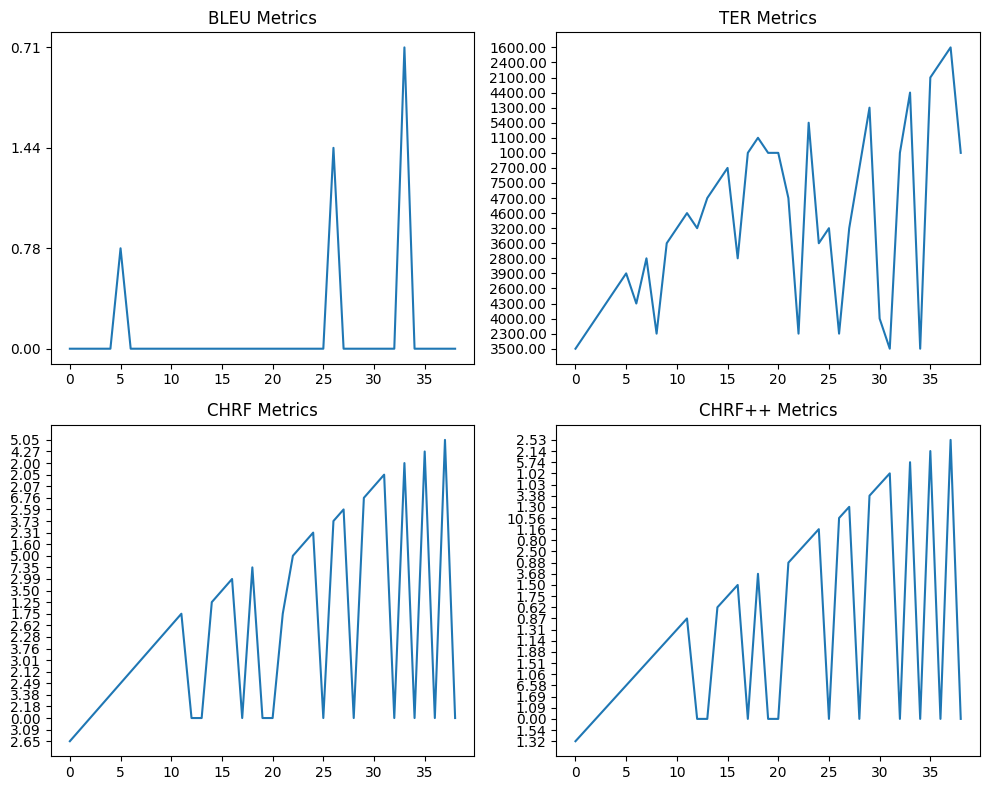

In [ ]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot bleu_metrics
axs[0, 0].plot(bleu_metrics)
axs[0, 0].set_title('BLEU Metrics')

# Plot ter_metrics
axs[0, 1].plot(ter_metrics)
axs[0, 1].set_title('TER Metrics')

# Plot chrf_metrics
axs[1, 0].plot(chrf_metrics)
axs[1, 0].set_title('CHRF Metrics')

# Plot chrfpp_metrics
axs[1, 1].plot(chrfpp_metrics)
axs[1, 1].set_title('CHRF++ Metrics')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

**Plot ROUGE**

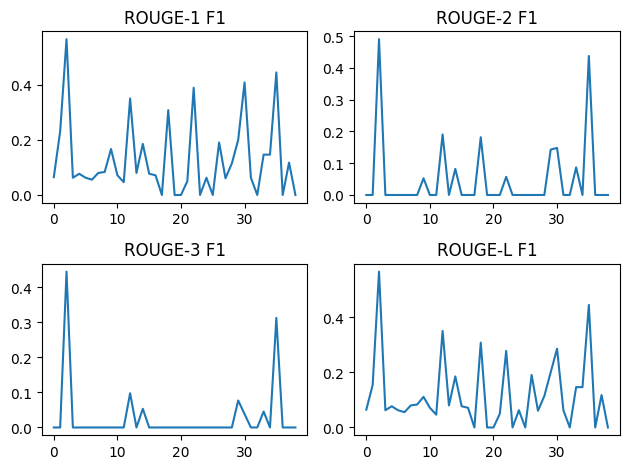

In [ ]:
# Create subplots
fig, axs = plt.subplots(2, 2)

# Plot each metric
axs[0, 0].plot(rouge_1_f_metrics)
axs[0, 0].set_title('ROUGE-1 F1')
axs[0, 1].plot(rouge_2_f_metrics)
axs[0, 1].set_title('ROUGE-2 F1')
axs[1, 0].plot(rouge_3_f_metrics)
axs[1, 0].set_title('ROUGE-3 F1')
axs[1, 1].plot(rouge_l_f_metrics)
axs[1, 1].set_title('ROUGE-L F1')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

**Plot METEOR**

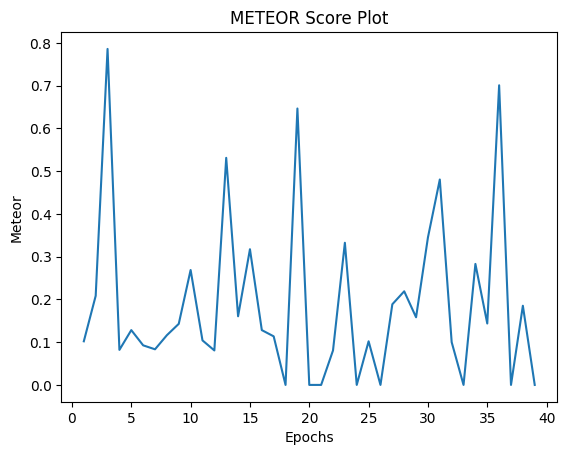

In [ ]:
epochs = range(1, len(meteor_metrics) + 1)

# Plotting the metrics
plt.plot(epochs, meteor_metrics)

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Meteor')
plt.title('METEOR Score Plot')

# Displaying the plot
plt.show()

**Plot Semantic Similarity**

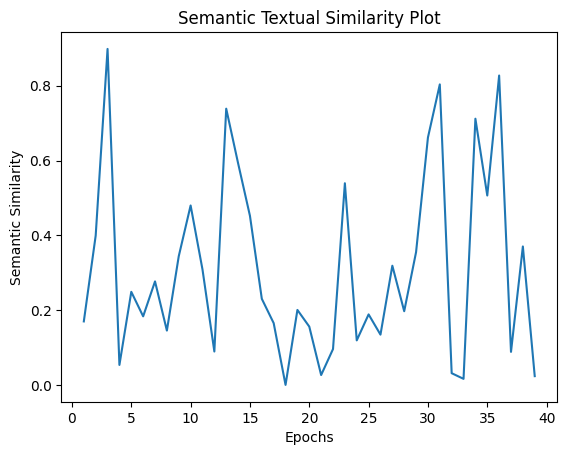

In [ ]:
epochs = range(1, len(similarity_metrics) + 1)

# Plotting the metrics
plt.plot(epochs, similarity_metrics)

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Semantic Similarity')
plt.title('Semantic Textual Similarity Plot')

# Displaying the plot
plt.show()

**Plot BERT**

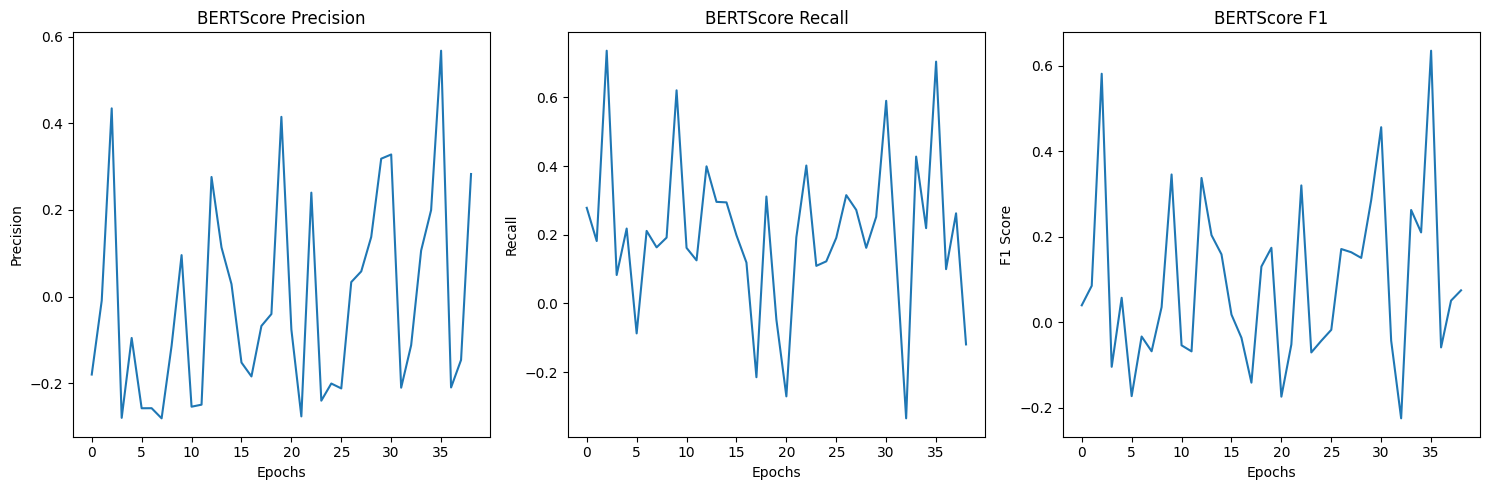

In [ ]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot each metric
axs[0].plot(bert_score_p_metrics)
axs[0].set_title('BERTScore Precision')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Precision')

axs[1].plot(bert_score_r_metrics)
axs[1].set_title('BERTScore Recall')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Recall')

axs[2].plot(bert_score_f1_metrics)
axs[2].set_title('BERTScore F1')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('F1 Score')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()